# k-Nearest Neighbors Regression from Scratch

## Prepare the Data

### Loading the Data

In [1]:
from sklearn import datasets
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load the diabetes toy dataset
diabetes = datasets.load_diabetes(as_frame = True)

In [2]:
# Take a look at the dataframe
data = diabetes["frame"]
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [3]:
# Print info about the dataframe
print(diabetes["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

### Selecting Features and Target Variable

In [4]:
# We will only use the following 3 features
features = ["age", "bmi", "bp"]

In [5]:
# Separate features and target variable
X = data[features].copy()
y = data["target"].copy()

### Normalizing the Data

Since kNN uses the euclidean distance to find the nearest neighbors, we need to normalize the data to make sure all features have the same bearing in the calculations. In this case, we will normalize the data using the min/max scaler.

In [6]:
# Normalize the data using the min/max scaler
X = (X - X.min()) / (X.max() - X.min())

### Splitting Training and Test Set

In [7]:
import numpy as np

# Permute the dataframe to kill any possible ordering used
np.random.seed(0)      # Fix a random seed to allow reproducibility
old_index = data.index
new_index = np.random.permutation(old_index)

X = X.loc[new_index].reset_index(drop = True)
y = y.loc[new_index].reset_index(drop = True)

In [8]:
# Use 80% of the data for training purposes and the remaining 20% for testing purposes
train_test_cut = int(np.floor(len(X)*0.8))

In [9]:
# Create the training set
X_train = X.iloc[: train_test_cut].copy()
y_train = y.iloc[: train_test_cut].copy()

In [10]:
# Create the test set
X_test = X.iloc[train_test_cut :].copy()
y_test = y.iloc[train_test_cut :].copy()

In [11]:
print("The training set has {} samples".format(len(X_train)))
print("The test set has {} samples".format(len(X_test)))

The training set has 353 samples
The test set has 89 samples


## Implement a k-Nearest Neighbors Regressor from Scratch

### Pseudo Code of the kNN Regression Algorithm

In the following we denote by $\bf x$ the collection of the training samples, by $\bf y$ the corresponding target values and by $\hat {\bf x}$ the collection of the new samples we are trying to predict.

1. For each $\hat x$ in $\hat {\bf x}$, find the distance between $\hat x$ and each $x$ in $\bf x$. 
2. For each $\hat x$ in $\hat {\bf x}$, use these distances to find its `k` nearest neighbors, i.e., the `k` training samples with minimal distance from $\hat x$ (here the `k` is an integer hyperparameter that is set at the beginning of the algorithm).
3. If we denote by $x_1,\dots, x_k$ these nearest neighbors, then the predicted value for the new sample $\hat x$ is $(y_1+\dots+ y_k) / k$, i.e., the average of the $\{y_i\}_{i = 1}^k$.

The metric used to compute distances is usually the Euclidean metric. However, the model we will implement will allow to use any $l_p$ distance. This is an infinite set of distances corresponding to the positive integers. More specifically, for any such $p$ the distance between the samples $x = (x_i)_{i=0}^n$ and $\hat x = (\hat {x}_i)_{i=0}^n$ is     
$$
\Big(\sum_{i=0}^n (x_i - \hat {x}_i)^p\Big)^{1/p}.
$$

### Coding Step 1

It's important to notice that the vast majority of the calculations are done during Step 1 when computing the distances. Once we obtain these distances, it is fast and easy to find the `k` nearest neighbors (for different values of `k`) and use them to make predictions. For this reason, in order to achieve decent execution times, we implement Step 1 separately.  

In [12]:
def find_distances(X, X_hat, p=2): # We set the same hyperparameter default values used by
                                   # sklearn's instance of kNN Regressor
    """
    Find the distances between the training data and the data we are trying to predict.
    
    :param X: the samples we use to train the model
    :type X: pandas.DataFrame of shape (n_samples, n_features)
    :param X_hat: the samples we want to predict
    :type X_hat: pandas.DataFrame of shape (n_queries, n_features)
    :param p: power parameter which determines which l_p metric is used. It must be in range (1, infty)
    :type p: int, default = 2; this results in the Euclidean metric being used
    
    :return: a dataframe of shape(n_queries, n_samples); the rows are the distances of a the samples we want to predict
             from each training sample 
    """     
    
    # Transpose the training data to have the indexes on the columns
    X = X.T
    # Find the distances between each new sample and each training sample
    distances = X.apply(lambda x : (((X_hat - x)**p).sum(axis = 1)) ** (1/p))
    
    return distances

### Coding the Rest of the Algorithm

In [13]:
def knn_predict(y, distances, n_neighbors=5): # We set the same hyperparameter default values used by
                                              # sklearn's instance of kNN Regressor
    """
    Run the k-Nearest Neighbors regression algorithm and use it to make predictions.
    
    :param y: the target values of the training data
    :type y: pandas.Series of shape (n_samples,)
    :param distances: the distances between all the training samples and the new samples
    :type distances: pd.DataFrame of shape (n_queries, n_samples)
    :param n_neighbors: the number of neighbors to use in the algorithm
    :type n_neighbors: int, default = 5
    
    :return: output, a dataframe with the following columns
                 "nearest_neighbors", contains the indexes of the k-nearest neighbors to each new sample we used
                 "predictions", contains the predicted values
    """
    
    # STEP 2: use the distances to find the nearest neighbors.
    #         The distances will be computed before running this function using the find_distances()
    nearest_neighbors = distances.apply(lambda x : x.sort_values(ascending = True).iloc[:n_neighbors].index, axis = 1)
    
    # STEP 3: use the nearest neighbors to predict the target variable
    predictions = nearest_neighbors.apply(lambda x : y.loc[x].mean())
    
    # Return a dataframe with both the nearest neighbors and the predicted values
    output = pd.DataFrame({"nearest_neighbors".format(n_neighbors) : nearest_neighbors,
                           "predictions" : predictions})
    
    return output                              

## Evaluating my kNN Regressor

In [14]:
# Initialize a dictionary to evaluate the performance of my kNN Regressor on the test data
my_test_errors = dict()
# Initialize the samples we want to predict (in this case, the test data)
X_hat = X_test

# Get the distances between the training samples and the samples we want to predict
distances = find_distances(X_train, X_hat)

# Use my kNN Regressor to predict the test data at different values of n_neighbors
# Evaluate the model using RMSE and collect all these values into a dictionary
for k in range(1, 11):  # We use values of k beetween 1 and 10
    knn_output = knn_predict(y_train, distances, k)
    my_test_predictions = knn_output["predictions"]
    my_test_errors[k] = np.sqrt((y_test - my_test_predictions).apply(lambda x : x**2).mean())

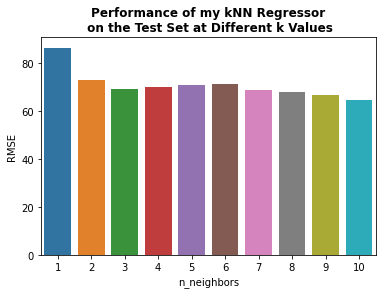

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the errors we obtain
sns.barplot(x = list(my_test_errors.keys()), y = list(my_test_errors.values()))
plt.xlabel("n_neighbors");
plt.ylabel("RMSE");
plt.title("Performance of my kNN Regressor\n on the Test Set at Different k Values", weight = "bold");

## Comparing my Model to sklearn's Implementation of kNN Regressor

In [16]:
from sklearn.neighbors import KNeighborsRegressor

# Now do the same thing using the sklearn's kNN Regressor

sklearn_test_errors = dict()

for k in range(1, 11):
    knn_regr = KNeighborsRegressor(n_neighbors = k)
    knn_regr.fit(X_train, y_train)
    sklearn_test_predictions = knn_regr.predict(X_test)  
    sklearn_test_errors[k] = np.sqrt((y_test - sklearn_test_predictions).apply(lambda x : x**2).mean())

KNeighborsRegressor(n_neighbors=1)

KNeighborsRegressor(n_neighbors=2)

KNeighborsRegressor(n_neighbors=3)

KNeighborsRegressor(n_neighbors=4)

KNeighborsRegressor()

KNeighborsRegressor(n_neighbors=6)

KNeighborsRegressor(n_neighbors=7)

KNeighborsRegressor(n_neighbors=8)

KNeighborsRegressor(n_neighbors=9)

KNeighborsRegressor(n_neighbors=10)

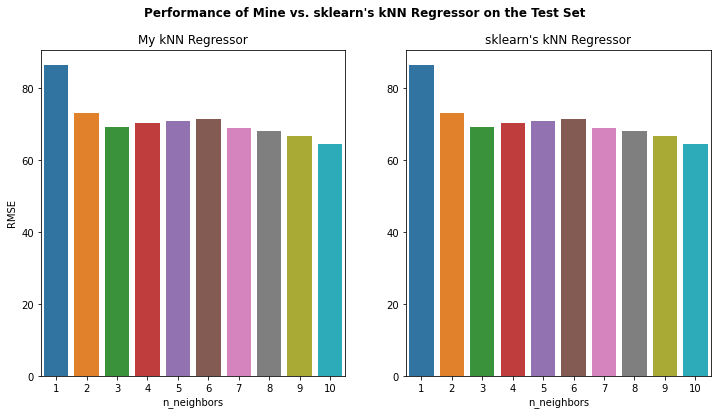

In [17]:
# Compare my kNN Regressor with the one from sklearn by plotting side by side the errors each of them yields 
# on the test data

fig, axs = plt.subplots(1,2, figsize = (12, 6))

_ = sns.barplot(x = list(my_test_errors.keys()), y = list(my_test_errors.values()), ax = axs[0]);
_ = sns.barplot(x = list(sklearn_test_errors.keys()), y = list(sklearn_test_errors.values()), ax = axs[1]);

_ = axs[0].set_ylabel("RMSE")

for ax in axs:
    _ = ax.set_xlabel("n_neighbors")

_ = axs[0].set_title("My kNN Regressor")    
_ = axs[1].set_title("sklearn's kNN Regressor")    

_ = fig.suptitle("Performance of Mine vs. sklearn's kNN Regressor on the Test Set", weight = "bold")

## Visualize the kNN Algorithm

In [18]:
from sklearn.decomposition import PCA

# Perform dimensionality reduction in order to be able to visualize the samples and the clusters
pca = PCA(n_components = 2) # We use 2 components so that we can use planar plots 
X_train_2D = pd.DataFrame(pca.fit_transform(X_train), index = X_train.index)
X_test_2D = pd.DataFrame(pca.fit_transform(X_test), index = X_test.index)

In [19]:
import time
from IPython.display import clear_output

def display_knn_prova(n_demos = 3, n_neighbors = 3):
    """
    Visualize the k-Nearest Neighbors algorithm by drawing a dynamic scatterplot with the training data, the training data and
    a random new sample, the training data, a random new sample and its nearest neighbors.
    
    :param n_demos: the number of demos to visualize
    :type n_demos: int, default = 3
    :param n_neighbors: the number of nearest neighbors to use
    :type n_neighborss: int, default = 3
    """
    
    # Pick random test samples
    random_samples = X_test_2D.sample(n_demos) 
    
    # Run knn to find all the nearest neighbors of all the test samples
    distances_2D = find_distances(X_train_2D, random_samples)
    knn_output_2D = knn_predict(y_train, distances_2D, n_neighbors)
    samples_nearest_neighbors = knn_output_2D["nearest_neighbors"]
    
    # Loop through the samples
    for i in range(n_demos):
        
        # Fix the current sample
        random_sample = random_samples.iloc[i]
        
        # Find the nearest neighbors to the current sample
        nearest_neighbors_index = samples_nearest_neighbors.iloc[i]
        nearest_neighbors = X_train_2D.loc[nearest_neighbors_index]
        
        # Draw scatterplot with the training data
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.legend(loc = "lower right");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
        # Draw scatterplot with the training data and the current test sample
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        ax.scatter(x = [random_sample[0]], y = [random_sample[1]],    # Draw the new sample in red
                   c = "r", alpha = 1, label = "new sample");
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.legend(loc = "lower right");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
        # Draw scatterplot with the training data, the current test sample and its nearest neighbors
        fig, ax = plt.subplots(figsize = (8,8))
        ax.scatter(x = X_train_2D.iloc[:, 0], y = X_train_2D.iloc[:, 1],    # Draw the training data in yellow
                   c = "y", label = "training data");
        ax.scatter(x = [random_sample[0]], y = [random_sample[1]],    # Draw the new sample in red
                   c = "r", alpha = 1, label = "new sample");
        ax.scatter(x = nearest_neighbors.iloc[:, 0], y = nearest_neighbors.iloc[:, 1],    # Draw the nearest neighbors in blue
                   c = "b", label = "nearest neighbors");
        plt.legend(loc = "lower right")
        plt.title("{}-Nearest Neighbors Algorithm".format(n_neighbors), weight = "bold");
        plt.show();
        time.sleep(3)  # Wait 3 seconds before drawing the next plot  
        clear_output(wait = True)  # Clear the current plot before drawing the next one
        
    return

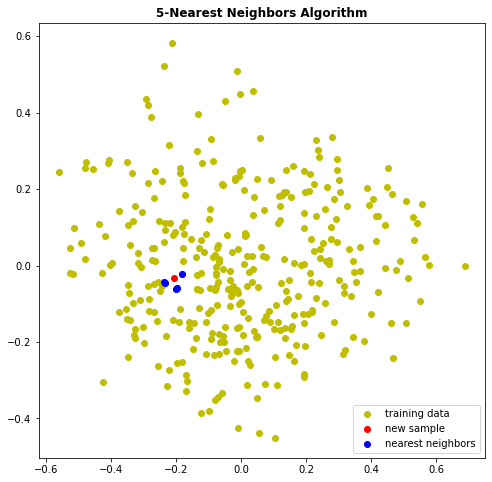

In [20]:
# Visualize knn algorithm
display_knn_prova(n_neighbors = 5)